# Low-pass IIR Filter
***

## Specification
***

1. Passband: $100Hz$
2. Max attenuation in passband: $1dB$
3. Stopband: $400Hz$
4. Min attenuation in stopband: $60dB$
5. Sampling Frequency used: $2kHz$
6. Cuttof frequency not specified, but I will try with $200Hz$

## Start point
***

First, let's project the analogic Butterworth filter that fits the specifications.

### Parameters
***

Let's convert $Hz$ to $rad$ that ends the pass-band and starts the stop-band.

$$\omega_{d1} = \frac{2\pi (F_c)}{F_s} =  \frac{2\pi 200}{2000} = 0.6283rad$$

$$\omega_{d2} = \frac{2\pi (stopband)}{F_s} =  \frac{2\pi 400}{2000} = 1.2566rad$$

The next step is compute the pre-warping. This part is essential to prevent the distortion in high frequencies once we digitize the filter.

$$\Omega_{a1} = 2F_stan\frac{\omega_{d1}}{2} = 1299.6788 rad/s$$
$$\Omega_{a2} = 2F_stan\frac{\omega_{d2}}{2} = 2906.1701 rad/s$$

So, the frequencies in $Hz$ after the pre-warping are: $f_{a1} = 206.8503Hz$ and $f_{a2} = 462.5313Hz$.

I won't show the demonstration of the next equation, but to calculate the order of the Butterworh filter, we must do:

$$N = \frac{log\frac{\frac{1}{|H_c(j\Omega_{a1})|^2} - 1}{\frac{1}{|H_c(j\Omega_{a2})|^2} - 1}}{2log\frac{\Omega_{a1}}{\Omega_{a2}}}$$

where:

- $|H_c(j\Omega_{a1})| = -3dB$ (We need to convert to absolute)
- $|H_c(j\Omega_{a2})| = -60dB$ (We need to convert to absolute)

Let's compute this with python


In [163]:
# Important imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fft_lib.fft import *
from scipy.signal.windows import kaiser
from scipy.fft import ifft
from scipy import signal

sns.set_theme()

In [165]:
alpha = 60
alpha_mag = 10**(-alpha/20)
fc_mag = 10**(-3/20)
passband = 100
stopband = 400
Fs = 2e3
Fc = 200

# converting Hz to rad
wd1 = 2*np.pi*Fc/Fs
wd2 = 2*np.pi*stopband/Fs

# pre-warping

fa1 = 2*Fs*np.tan(wd1/2)/(2*np.pi)
fa2 = 2*Fs*np.tan(wd2/2)/(2*np.pi)

# N
N = int(np.round(np.log10((1/fc_mag**2 - 1)/(1/alpha_mag**2 - 1))/(2*np.log10(fa1/fa2))))
print(f'Order: {N}')

Order: 9


So, we will need a $9th$ order filter to achieve the specifications. Ther will be $18$ poles. the equation to compute all the poles are:

$$s_k = \Omega_{a1}e^{j\frac{\pi}{2}N(2k+N-1)}$$



Poles are:
s_0 = (-225.68685255574695+1279.9337438261505j)
s_1 = (-649.8393924658122+1125.5548445104794j)
s_2 = (-995.6117110364967+835.4174195265053j)
s_3 = (-1221.2985635922437+444.5163242996456j)
s_4 = (-1299.6787849316252+1.591647463886236e-13j)
s_5 = (-1221.298563592244-444.5163242996453j)
s_6 = (-995.6117110364968-835.4174195265051j)
s_7 = (-649.8393924658131-1125.554844510479j)
s_8 = (-225.68685255574698-1279.9337438261505j)
s_9 = (225.68685255574653-1279.9337438261507j)
s_10 = (649.8393924658127-1125.5548445104791j)
s_11 = (995.6117110364964-835.4174195265055j)
s_12 = (1221.2985635922435-444.5163242996463j)
s_13 = (1299.6787849316252-3.183294927772472e-13j)
s_14 = (1221.2985635922441+444.5163242996446j)
s_15 = (995.6117110364969+835.4174195265049j)
s_16 = (649.8393924658133+1125.554844510479j)
s_17 = (225.68685255574712+1279.9337438261505j)


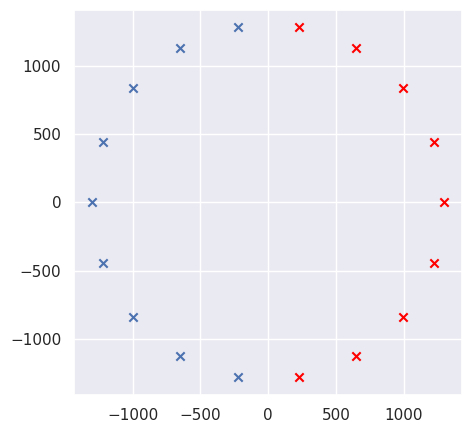

In [223]:
k = np.arange(1, 2*N + 1)
s = (fa1*2*np.pi)*np.exp(1j*(np.pi/(2*N))*(2*k+N-1))

print('Poles are:')
for i, pole in enumerate(s):
    print(f's_{i} = {pole}')

plt.figure(figsize=(5, 5))

plt.scatter(s.real[0:N], s.imag[0:N], marker='x')
plt.scatter(s.real[N::], s.imag[N::], color='red', marker='x')

plt.show()

The filter will have the response:

$$H(s) = \frac{G}{\prod_{i=1}^N(s - p_i)}$$

$$G = H(0) = \prod_{i=1}^N(-p_i)$$

We will only use the first $N$ poles that are at left of the complex plane
Let's see if this response fits the specifications:

Gain: (1.0580940417240666e+28-14568529068032j)


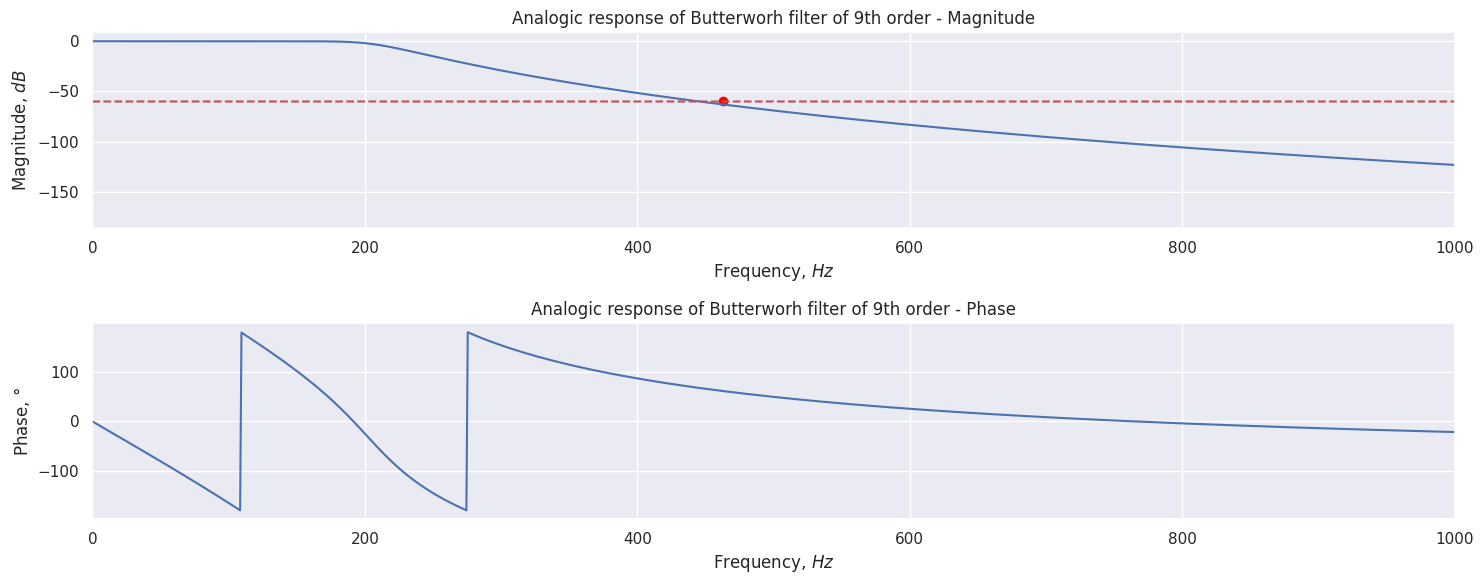

In [201]:
G = np.prod(-s[0:N])
print(f'Gain: {G}')

w = np.linspace(0, 2*np.pi, 2048)
ss = 1j*w*Fs
# ss = 1j*(2*Fs*np.tan(w/2))

H = G
for i, pole in enumerate(s):
    if i < N:
        H *= 1/(ss - pole)
    else:
        break

mag_H = 20*np.log10(np.abs(H))

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(w*Fs/(2*np.pi), mag_H)
plt.xlim(0, Fs/2)
plt.plot(w*Fs/(2*np.pi), w.size*[-alpha], '--r')
plt.scatter(fa2, -60, color='red')
plt.title(f'Analogic response of Butterworh filter of {N}th order - Magnitude')
plt.xlabel('Frequency, $Hz$')
plt.ylabel('Magnitude, $dB$')

plt.subplot(2, 1, 2)
plt.plot(w*Fs/(2*np.pi), np.angle(H, deg= True))
plt.xlim(0, Fs/2)
plt.title(f'Analogic response of Butterworh filter of {N}th order - Phase')
plt.xlabel('Frequency, $Hz$')
plt.ylabel('Phase, $°$')


plt.tight_layout()

The filter can be considered linear inside the pass-band. So, let's try convert this filter to the digital world

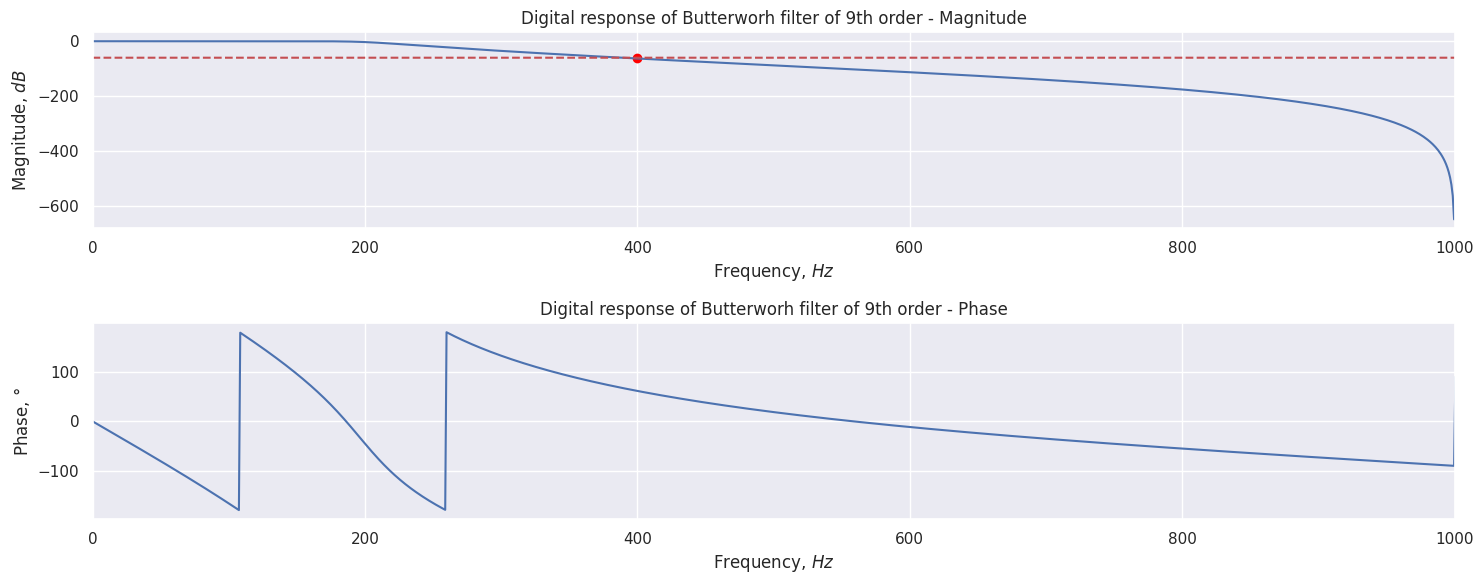

In [213]:
z = np.exp(1j*w)

s_digital = (2*Fs)*(1-z**(-1))/(1+z**(-1))

Hd = G
for i, pole in enumerate(s):
    if i < N:
        Hd *= 1/(s_digital - pole)
    else:
        break

mag_Hd = 20*np.log10(np.abs(Hd))

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot((w*Fs)/(2*np.pi), mag_Hd)
plt.xlim(0, Fs/2)
plt.plot(w*Fs/(2*np.pi), w.size*[-alpha], '--r')
plt.scatter(stopband, -60, color='red')
plt.title(f'Digital response of Butterworh filter of {N}th order - Magnitude')
plt.xlabel('Frequency, $Hz$')
plt.ylabel('Magnitude, $dB$')

plt.subplot(2, 1, 2)
plt.plot((w*Fs)/(2*np.pi), np.angle(Hd, deg= True))
plt.xlim(0, Fs/2)
plt.title(f'Digital response of Butterworh filter of {N}th order - Phase')
plt.xlabel('Frequency, $Hz$')
plt.ylabel('Phase, $°$')


plt.tight_layout()

The conversion was succesful! Let's finally filter our signal

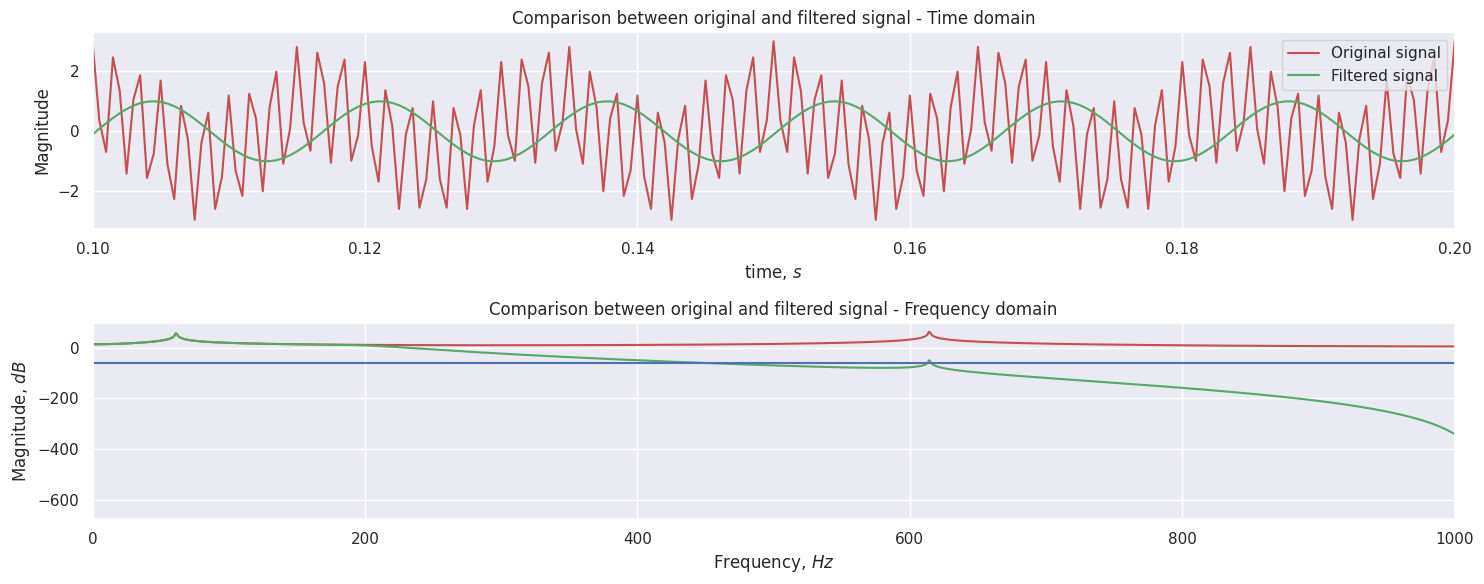

In [246]:
t = np.arange(0, (2048/Fs), step=(1/Fs))

y = np.cos(2*np.pi*60*t) + 2*np.cos(2*np.pi*600*t)

plt.figure(figsize=(15,6))

my_fft = FFT(2048)
Y = my_fft.fft_calc(y)
Y_filtered = Y*Hd

k = np.arange(0, 2048)
y_filtered = ifft(Y_filtered)

mag_y = 20*np.log10(np.abs(Y))
mag_y_filtered = 20*np.log10(np.abs(Y_filtered))

plt.subplot(2, 1, 1)
plt.plot(t, y, '-r')
plt.plot(t, y_filtered.real, '-g')
plt.xlabel('time, $s$')
plt.ylabel('Magnitude')
plt.title('Comparison between original and filtered signal - Time domain')
# Ploting a range after the transitory period
plt.xlim(0.1, 0.2)
plt.legend(["Original signal", "Filtered signal"])

plt.subplot(2 ,1 ,2)
plt.plot(k, mag_y, '-r')
plt.plot(k, mag_y_filtered, '-g')
plt.plot(k, k.size*[-60])
plt.xlabel('Frequency, $Hz$')
plt.ylabel('Magnitude, $dB$')
plt.title('Comparison between original and filtered signal - Frequency domain')
plt.xlim(0, Fs/2)
np.save('fir', y_filtered)
plt.tight_layout()

